In [1]:
import numpy as np
import matplotlib.pyplot as plt

from imripy import merger_system as ms
from imripy import halo, inspiral, waveform, plot_utils, detector

from scipy.interpolate import interp1d

In [2]:
m1 = 1e4 * ms.solar_mass_to_pc
m2 = 1. *  ms.solar_mass_to_pc
D = 5e8

In [91]:
gamma = 5./3.
Kappa= 2.2e-1
r_c = 60.*m1
print(Kappa)
maDisc = halo.MichelAccretion(m1, r_c, Kappa, gamma)
print(maDisc)

0.22
MichelAccretion(M=4.8e-10, M_dot=3.4524237417241263e-18, M_dot/M_dot_Edd=1.0017259796063183, rho_c=0.003628439432128441, u_c=0.09128709291752768, kappa=0.22, Gamma=1.6666666666666667)


In [92]:
rho_ism = 1e-24 * ms.g_cm3_to_invpc2

In [93]:
rho6 = 1.5e15 * ms.solar_mass_to_pc  # in 1/pc^2 
alpha = 7./3.
spike = halo.Spike.FromRho6(rho6, m1, alpha)

In [94]:
sp_0 = ms.SystemProp(m1, m2, halo.ConstHalo(0.), D=D)
r_grid = np.geomspace(sp_0.r_schwarzschild(), 200*sp_0.r_isco(), 500)
maDisc_int = halo.InterpolatedHalo(r_grid, maDisc.density(r_grid))
maDisc_int.velocity = interp1d(r_grid, maDisc.velocity(r_grid), kind='cubic')
maDisc_int.soundspeed = interp1d(r_grid, maDisc.soundspeed(r_grid), kind='cubic')
sp_b = ms.SystemProp(m1, m2, halo.ConstHalo(0.), baryonicHalo = maDisc_int, D=D)

/media/data/Documents/PhD/imripy/src/imripy/halo.py:790: RuntimeWarning: invalid value encountered in power
  cs2 = 1./ ( 1./(self.Gamma*self.kappa* rho**(self.Gamma-1.)) + 1./(self.Gamma-1.) )


/media/data/Documents/PhD/imripy/src/imripy/halo.py:790: RuntimeWarning: invalid value encountered in power
  cs2 = 1./ ( 1./(self.Gamma*self.kappa* rho**(self.Gamma-1.)) + 1./(self.Gamma-1.) )


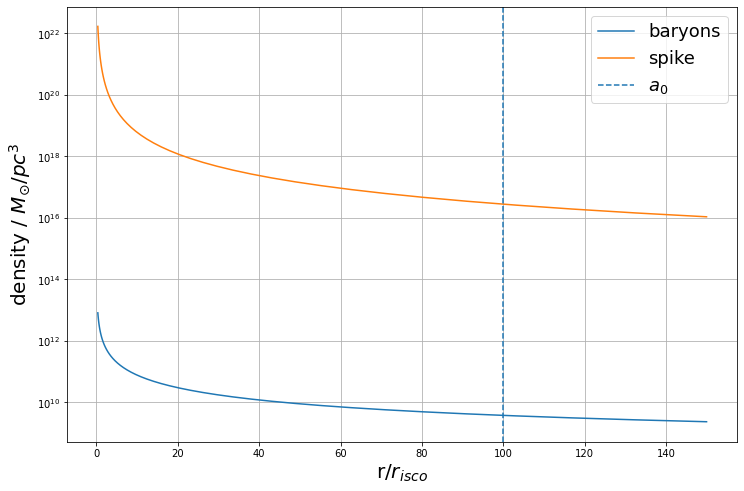

In [96]:
plt.figure(figsize=(12,8))
r_grid = np.geomspace(2*m1, 150*sp_0.r_isco())
l, = plt.plot(r_grid/sp_0.r_isco(), maDisc.density(r_grid)/ms.solar_mass_to_pc, label="baryons")
              #label="$\\rho_{\\infty}=" + f"{maDisc.M_dot/(2.2 * 1e-9 * maDisc.M /0.3064):.0e}" + "M_{Edd}$")
#plt.plot(r_grid, maDisc.mass(r_grid), color = l.get_c(), linestyle='--')

plt.plot(r_grid/sp_0.r_isco(), spike.density(r_grid)/ms.solar_mass_to_pc, label='spike')
#plt.axhline(rho_ism/ms.solar_mass_to_pc, linestyle='--', label="ISM")
#plt.axvline(2.*m1/m1, color='black')
plt.axvline(100., linestyle='--', label="$a_0$")
plt.yscale('log');# plt.xscale('log') 
plt.xlabel("r/$r_{isco}$", fontsize=20); plt.ylabel("density / $M_{\odot}/pc^3$", fontsize=20)
plt.grid(); plt.legend(fontsize=18)

### Compare accretion

In [13]:
accuracy = 1e-9
opt_0 = inspiral.Classic.EvolutionOptions(accuracy=accuracy, verbose=1)
baryonicOptions_acc = inspiral.Classic.EvolutionOptions(accuracy=accuracy, verbose=1, accretion=True, accretionModel='Bondi-Hoyle')
baryonicOptions_nacc = inspiral.Classic.EvolutionOptions(accuracy=accuracy, verbose=1, accretion=False)

opt_acc = inspiral.Classic.EvolutionOptions(baryonicHaloEffects=True, baryonicEvolutionOptions=baryonicOptions_acc, accuracy=accuracy, verbose=1)
opt_nacc = inspiral.Classic.EvolutionOptions(baryonicHaloEffects=True, baryonicEvolutionOptions=baryonicOptions_nacc, accuracy=accuracy, verbose=1)


In [14]:
a0 = 100. * sp_0.r_isco()
e0 = 0.1

In [15]:
ev_0 = inspiral.Classic.Evolve(sp_0, a0, e0, opt=opt_0)
ev_acc = inspiral.Classic.Evolve(sp_b, a0, e0, opt=opt_acc)
ev_nacc = inspiral.Classic.Evolve(sp_b, a0, e0, opt=opt_nacc)

Evolving from  100.0  to  1.0 r_isco  with initial eccentricity 0.1  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-09
A termination event occurred.
 -> Evolution took 0.8166s
Evolving from  100.0  to  1.0 r_isco  with initial eccentricity 0.1  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-09, baryonicHaloEffects = True
A termination event occurred.
 -> Evolution took 26.2679s
Evolving from  100.0  to  1.0 r_isco  with initial eccentricity 0.1  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-09, baryonicHaloEffects = True
A termination event occurred.
 -> Evolution took 10.2166s


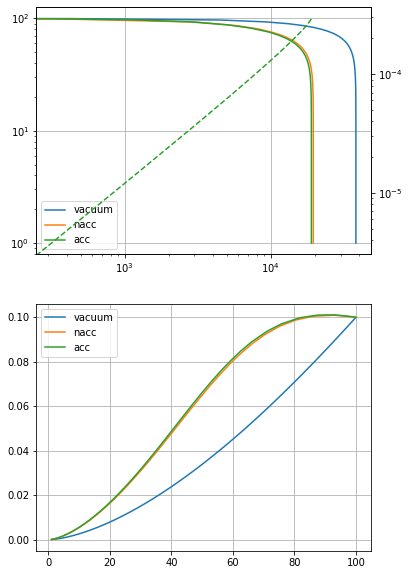

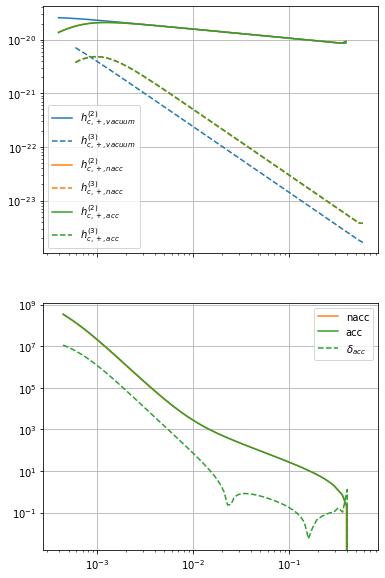

In [16]:
fig_ae, axes_ae = plt.subplots(2, 1, figsize=(6,10))
fig_gw, axes_gw = plt.subplots(2, 1, sharex='col', figsize=(6,10))

ax_m = axes_ae[0].twinx()
l = plot_utils.plotEvolution(sp_0, ev_0, ax_a=axes_ae[0], ax_ae=axes_ae[1], label='vacuum')
plot_utils.plotGWcharacteristicStrain(sp_0, ev_0, axes_gw[0], label='vacuum' , harmonics=[2,3], color=l.get_c())

l = plot_utils.plotEvolution(sp_b, ev_nacc, ax_a=axes_ae[0], ax_ae=axes_ae[1], label='nacc')
plot_utils.plotGWcharacteristicStrain(sp_b, ev_nacc, axes_gw[0], label='nacc' , harmonics=[2,3], color=l.get_c())
plot_utils.plotDeltaN(sp_0, ev_0, sp_b, ev_nacc, axes_gw[1], color=l.get_c(), label='nacc')

l = plot_utils.plotEvolution(sp_b, ev_acc, ax_a=axes_ae[0], ax_ae=axes_ae[1], ax_m=ax_m, m2=m2, label='acc')
plot_utils.plotGWcharacteristicStrain(sp_b, ev_acc, axes_gw[0], label='acc' , harmonics=[2,3], color=l.get_c())
plot_utils.plotDeltaN(sp_0, ev_0, sp_b, ev_acc, axes_gw[1], color=l.get_c(), label='acc')

plot_utils.plotDeltaN(sp_b, ev_nacc, sp_b, ev_acc, axes_gw[1], color=l.get_c(), label='$\delta_{acc}$', linestyle='--')

for ax in axes_ae:
    ax.grid(); ax.legend()
for ax in axes_gw:
    ax.grid(); ax.legend()

### Compare with DM

In [97]:
sp_dm = ms.SystemProp(m1, m2, spike, D=D)
sp_dm_b = ms.SystemProp(m1, m2, spike, baryonicHalo = maDisc, D=D)

In [98]:
def makeDynamicSpike(sp_stat):
    extPotential = lambda r:sp_stat.m1/r
    r_grid = np.geomspace(1e-1*sp_stat.r_isco(), 1e8*sp_stat.r_isco(), 100)
    Eps_grid = np.geomspace(extPotential(r_grid[-1]), extPotential(r_grid[0]), 500)
    dynSpike = halo.DynamicSS.FromSpike(Eps_grid, sp_stat, sp_stat.halo)
    sp_dyn = ms.SystemProp(sp_stat.m1, sp_stat.m2, dynSpike, sp_stat.D)
    return sp_dyn
sp_dm = makeDynamicSpike(sp_dm)
sp_dm_b.halo = sp_dm.halo

In [99]:
a0 = 100. * sp_0.r_isco()
e0 = 0.4
accuracy = 1e-10
opt_0 = inspiral.Classic.EvolutionOptions(accuracy=accuracy, verbose=1)
baryonicOptions = inspiral.Classic.EvolutionOptions(accretion=True, accretionModel='Bondi-Hoyle', accuracy=accuracy, verbose=1)
opt_b = inspiral.Classic.EvolutionOptions(baryonicHaloEffects=True, baryonicEvolutionOptions=baryonicOptions, accuracy=accuracy, verbose=1)
opt_dm = inspiral.Classic.EvolutionOptions(haloPhaseSpaceDescription=True, accuracy=accuracy, verbose=1)
opt_dm_b = inspiral.Classic.EvolutionOptions(haloPhaseSpaceDescription=True, baryonicHaloEffects=True, baryonicEvolutionOptions=baryonicOptions, accuracy=accuracy, verbose=1)


In [100]:
ev_0 = inspiral.Classic.Evolve(sp_0, a0, e0, opt=opt_0)
ev_b = inspiral.Classic.Evolve(sp_b, a0, e0, opt=opt_b)

Evolving from  100.0  to  1.0 r_isco  with initial eccentricity 0.4  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-10
A termination event occurred.
 -> Evolution took 1.0737s
Evolving from  100.0  to  1.0 r_isco  with initial eccentricity 0.4  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-10, baryonicHaloEffects = True
A termination event occurred.
 -> Evolution took 41.6215s


In [101]:
ev_dm = inspiral.Classic.Evolve(sp_dm, a0, e0, opt=opt_dm)
ev_dm_b = inspiral.Classic.Evolve(sp_dm_b, a0, e0, opt=opt_dm_b)

Evolving from  100.0  to  1.0 r_isco  with initial eccentricity 0.4  with  Options: accretion = False, haloPhaseSpaceDescription = True, accuracy = 1.0e-10
A termination event occurred.
 -> Evolution took 14.1738s
Evolving from  100.0  to  1.0 r_isco  with initial eccentricity 0.4  with  Options: accretion = False, haloPhaseSpaceDescription = True, accuracy = 1.0e-10, baryonicHaloEffects = True


/media/data/Documents/PhD/imripy/src/imripy/halo.py:790: RuntimeWarning: invalid value encountered in power
  cs2 = 1./ ( 1./(self.Gamma*self.kappa* rho**(self.Gamma-1.)) + 1./(self.Gamma-1.) )


A termination event occurred.
 -> Evolution took 1047.1493s


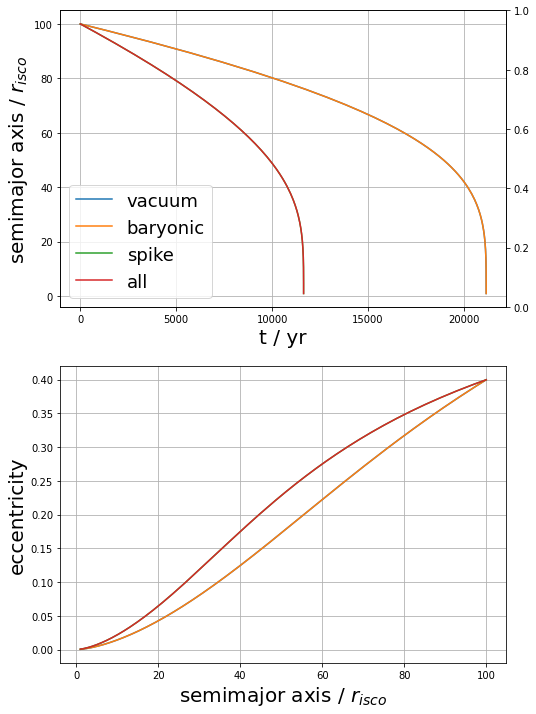

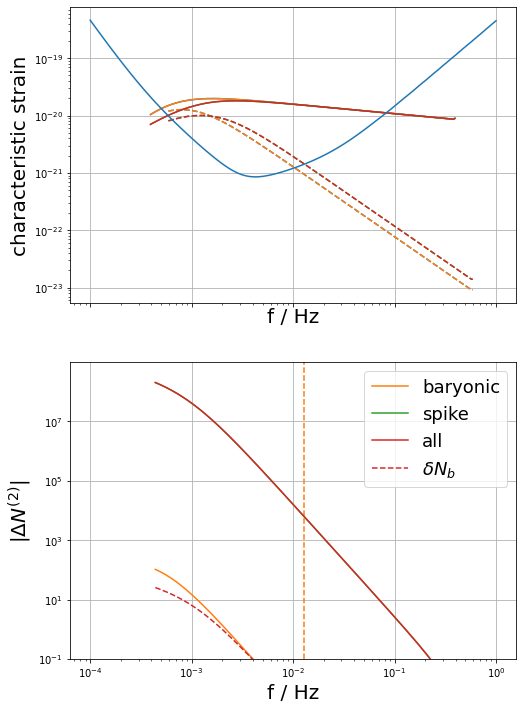

In [111]:
fig_ae, axes_ae = plt.subplots(2, 1, figsize=(8,12))
fig_gw, axes_gw = plt.subplots(2, 1, sharex='col', figsize=(8,12))

ax_m = axes_ae[0].twinx()
l = plot_utils.plotEvolution(sp_0, ev_0, ax_a=axes_ae[0], ax_ae=axes_ae[1], label='vacuum')
plot_utils.plotGWcharacteristicStrain(sp_0, ev_0, axes_gw[0], label='vacuum' , harmonics=[2,3], color=l.get_c())

l = plot_utils.plotEvolution(sp_b, ev_b, ax_a=axes_ae[0], ax_ae=axes_ae[1], m2=m2, label='baryonic')
plot_utils.plotGWcharacteristicStrain(sp_b, ev_b, axes_gw[0], label='baryonic' , harmonics=[2,3], color=l.get_c())
plot_utils.plotDeltaN(sp_0, ev_0, sp_b, ev_b, axes_gw[1], plotFgw5year=True, color=l.get_c(), label='baryonic')

l = plot_utils.plotEvolution(sp_dm, ev_dm, ax_a=axes_ae[0], ax_ae=axes_ae[1], label='spike')
plot_utils.plotGWcharacteristicStrain(sp_dm, ev_dm, axes_gw[0], label='dm' , harmonics=[2,3], color=l.get_c())
plot_utils.plotDeltaN(sp_0, ev_0, sp_dm, ev_dm, axes_gw[1], color=l.get_c(), label='spike')

#plot_utils.plotDeltaN(sp_dm, ev_dm, sp_b, ev_b, axes_gw[1], color=l.get_c(), label='spike vs baryonic', linestyle='--')

l = plot_utils.plotEvolution(sp_dm_b, ev_dm_b, ax_a=axes_ae[0], ax_ae=axes_ae[1], m2=m2, label='all')
plot_utils.plotGWcharacteristicStrain(sp_dm_b, ev_dm_b, axes_gw[0], label='all' , harmonics=[2,3], color=l.get_c())
plot_utils.plotDeltaN(sp_0, ev_0, sp_dm_b, ev_dm_b, axes_gw[1], color=l.get_c(), label='all')

plot_utils.plotDeltaN(sp_dm, ev_dm, sp_dm_b, ev_dm_b, axes_gw[1], color=l.get_c(), label="$\delta N_{b}$", linestyle='--')

f_gw = np.geomspace(detector.Lisa().Bandwith()[0], detector.Lisa().Bandwith()[1], 100)
axes_gw[0].loglog(f_gw/ms.hz_to_invpc, detector.Lisa().NoiseStrain(f_gw), label='LISA')

axes_ae[0].set_yscale('linear'); axes_ae[0].set_xscale('linear')
axes_ae[0].legend(fontsize=18)
axes_ae[0].set_xlabel("t / yr", fontsize=20); axes_ae[0].set_ylabel("semimajor axis / $r_{isco}$",fontsize=20)
axes_ae[1].set_xlabel("semimajor axis / $r_{isco}$", fontsize=20); axes_ae[1].set_ylabel("eccentricity",fontsize=20)
axes_gw[0].set_xlabel("f / Hz", fontsize=20); axes_gw[0].set_ylabel("characteristic strain",fontsize=20)
axes_gw[1].set_xlabel("f / Hz", fontsize=20); axes_gw[1].set_ylabel("$|\Delta N^{(2)}|$",fontsize=20)
axes_gw[1].set_ylim(bottom=0.1)
axes_gw[1].legend(fontsize=18)
for ax in np.append(axes_ae.flatten(), axes_gw.flatten()):
    ax.grid()